## Introduction

#### Motivation

We are interested in helping revamp the ATOC Skywatch data archives and make the data more accessible and easier to visualize. We chose to work with data from the ceilometer and pyrgeometer and look at the cloud base heights as well as derive the cloud base heights using Stefan-Boltzmann's Law. We then turned our data reader into a function so that we could create a 'climatology' of cloud base data to see if there are any useful trends. 

#### Data Sets Used and References

1. Skywatch Archives: Ceilometer
2. Skywatch Archives: Pyrgeometer
3. https://en.wikipedia.org/wiki/Pyrgeometer
4. http://weather.uwyo.edu/upperair/sounding.html

## Algorithm

#### Cielometer Data - For One Day

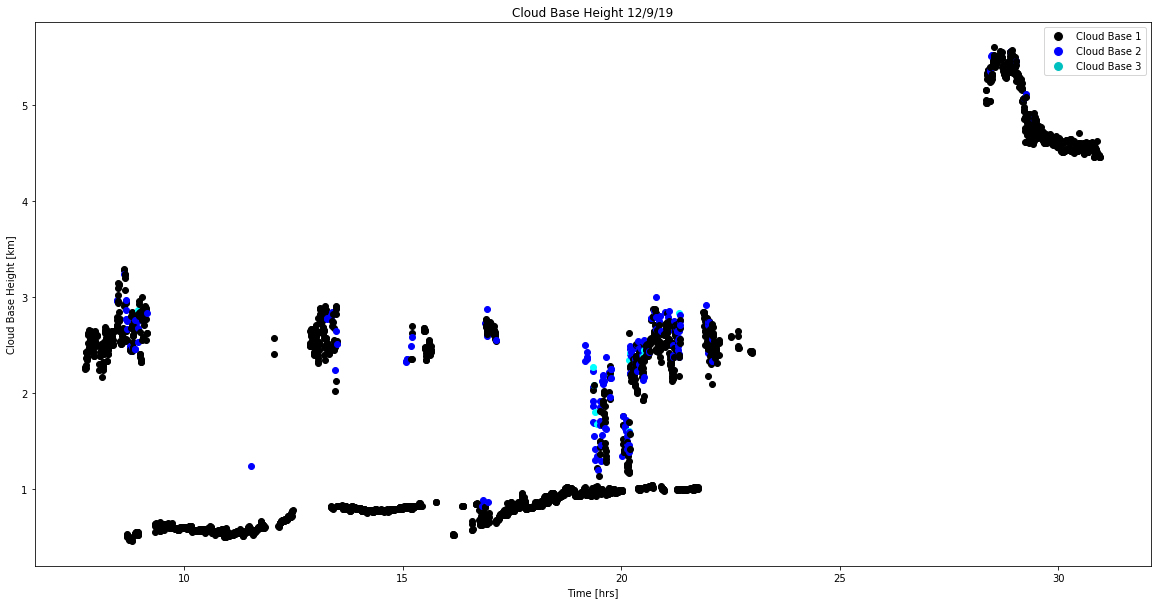

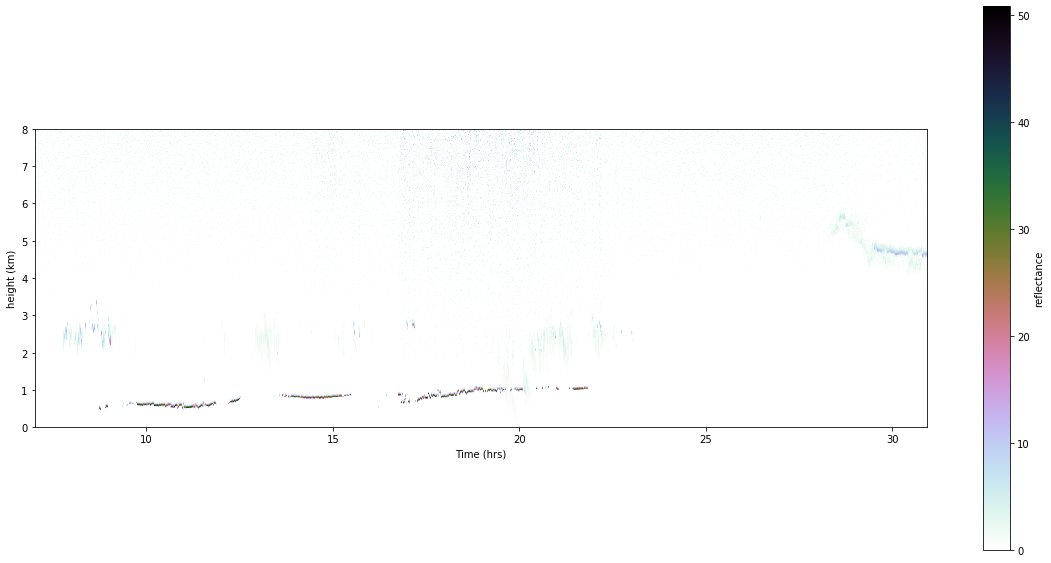

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import urllib
from matplotlib.lines import Line2D
import datetime 
%matplotlib inline

url    = 'https://skywatch.colorado.edu/data/ceil_19_12_09.dat'
lines  = urllib.request.urlopen(url).readlines()

# Loop over the lines in the file
utc=[] # initialize list for times
cloud_base1 = [] #initialize lists for cloud base heights
cloud_base2 = []
cloud_base3 = []

timesteps = len(lines) - 5 #Number of timesteps in the datafile. Minus five due to header lines

reflectance_data = np.zeros((770,timesteps)) #initialize reflectance data array

#Loop through all lines in datafile. 
for i,line in enumerate(lines):
    entries = line.decode("utf-8").split("\t")
    #print(entries);quit()
    if entries[0][0] != ';':
        utc.append(float(entries[0][0:2]) + \
                   float(entries[0][3:5])/60. + \
                   float(entries[0][6:8])/3600.)
        cloud_base1.append(float(entries[1])/1000)  
        cloud_base2.append(float(entries[2])/1000)
        cloud_base3.append(float(entries[3])/1000)
    
        #Create the reflectance data matrix
        ref1 = np.array(entries[4:774], dtype=np.float64) 
        reflectance_data[:,i-5] = ref1
        
        #Initialize a variable to capture the start time of the dataset
        if i==5:
            start_time = int(float(entries[0][0:2]) + \
                   float(entries[0][3:5])/60. + \
                   float(entries[0][6:8])/3600.)

#Ensure that the time does not start over after 24 hours and is continuous 
utc=np.array(utc)
next_day=np.where(utc < start_time)
utc[next_day]=utc[next_day]+24.
   
#Prepare reflectance data for plotting
reflectance_data = np.flipud(reflectance_data)
reflectance_data = np.where(reflectance_data < 0 , 0, reflectance_data)
plt.figure(figsize = [20, 10])

#Plot cloud base heights that are not zero
for i in range(len(cloud_base1)):
    
    if cloud_base1[i] != 0: 
        plt.plot(utc[i], cloud_base1[i], 'o', color = 'black')
        
    if cloud_base2[i] != 0:
        plt.plot(utc[i], cloud_base2[i], 'o', color= 'blue')
    
    if cloud_base3[i] != 0:
        plt.plot(utc[i], cloud_base3[i], 'o', color= 'cyan')
        
plt.xlabel('Time [hrs]')
plt.ylabel('Cloud Base Height [km]')
plt.title('Cloud Base Height 12/9/19')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cloud Base 1', markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cloud Base 2', markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cloud Base 3', markerfacecolor='c', markersize=10)]

plt.legend(handles=legend_elements)

plt.show()

#Plot reflectance data
size = [utc[0], utc[-1], 0, 8]

fig = plt.figure(figsize = [20, 10])
plt.imshow(reflectance_data, cmap = 'cubehelix_r', extent = size)
plt.xlabel('Time (hrs)')
plt.ylabel('height (km)')
plt.colorbar(label='reflectance')
plt.show()

#### Pyrgeometer Data - One Day

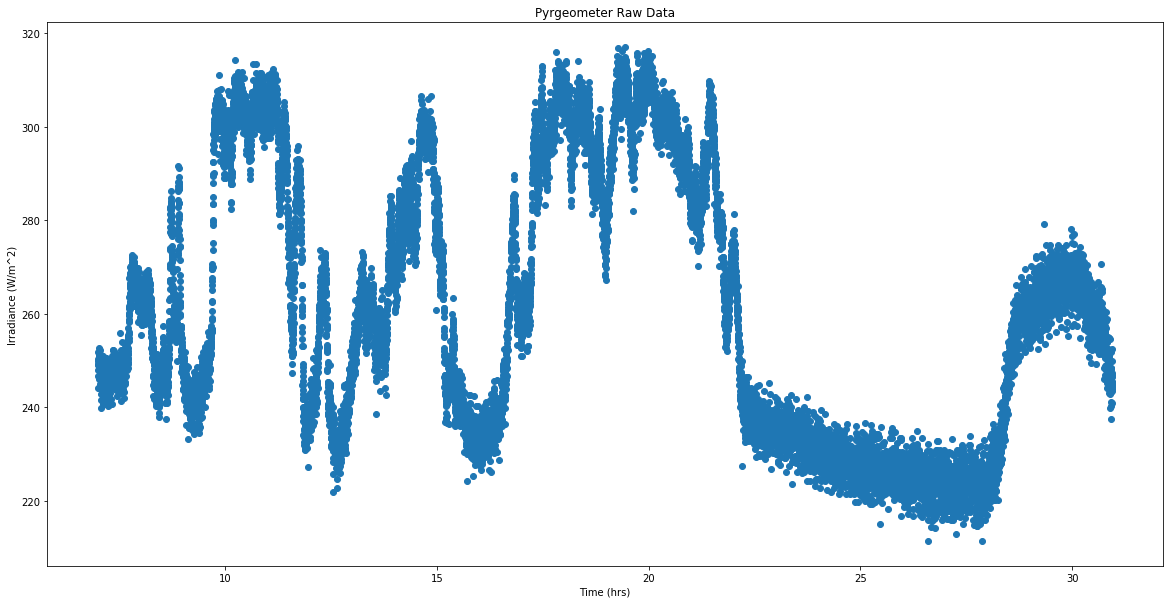

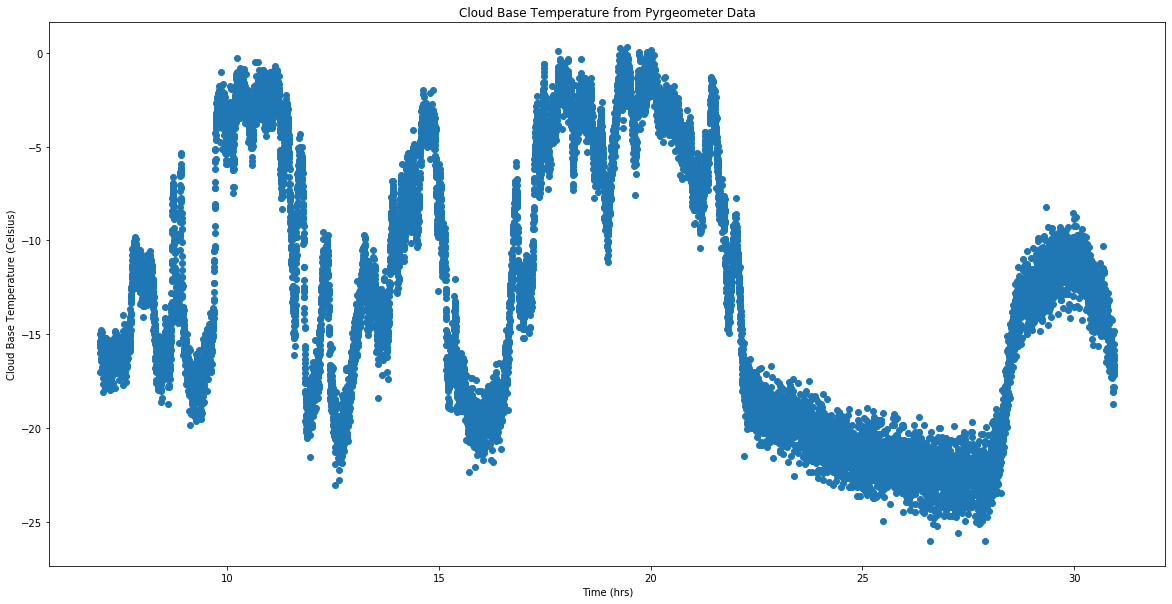

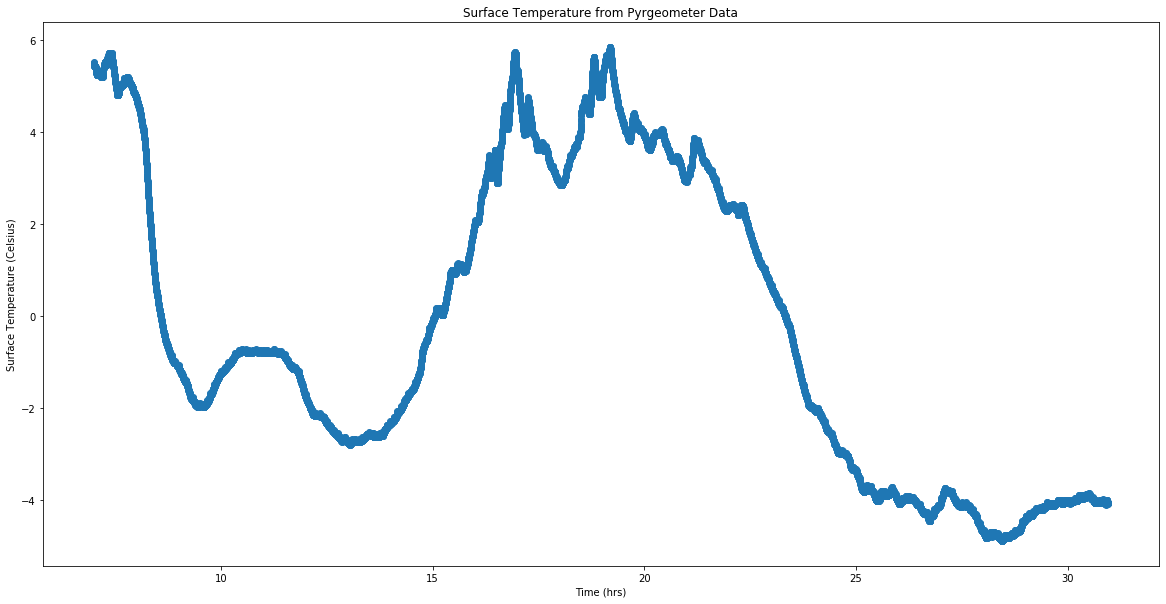

In [2]:
url    = 'https://skywatch.colorado.edu/data/pyrg_19_12_09.dat'
lines  = urllib.request.urlopen(url).readlines()

# Loop over the lines in the file
utc_p=[] # initialize list for times
irradiance = []
surface_temp = []
T_derived = []




for i,line in enumerate(lines):
    entries = line.decode("utf-8").split("\t")
    #print(entries);quit()
    if entries[0][0] != ';':
        utc_p.append(float(entries[0][0:2]) + \
                   float(entries[0][3:5])/60. + \
                   float(entries[0][6:8])/3600.)
        irradiance.append(float(entries[1]))  
        surface_temp.append(float(entries[3]) - 273.1) #Celsius 
        
        #Calculate derived temperature using Stefan Boltzmann's Law
        T_derived.append((float(entries[1])/(5.67*10**(-8)))**(1/4) - 273.15)
        
        
        if i==5:
            start_time = int(float(entries[0][0:2]) + \
                   float(entries[0][3:5])/60. + \
                   float(entries[0][6:8])/3600.)
utc_p=np.array(utc_p)
next_day=np.where(utc_p < start_time)
utc_p[next_day]=utc_p[next_day]+24.




plt.figure(figsize = [20, 10])
plt.scatter(utc_p, irradiance)
plt.xlabel('Time (hrs)')
plt.ylabel('Irradiance (W/m^2)')
plt.title('Pyrgeometer Raw Data')
plt.show()

plt.figure(figsize = [20, 10])
plt.scatter(utc_p, T_derived)
plt.xlabel('Time (hrs)')
plt.ylabel('Cloud Base Temperature (Celsius)')
plt.title('Cloud Base Temperature from Pyrgeometer Data')
plt.show()


plt.figure(figsize = [20, 10])
plt.scatter(utc_p, surface_temp)
plt.xlabel('Time (hrs)')
plt.ylabel('Surface Temperature (Celsius)')
plt.title('Surface Temperature from Pyrgeometer Data')
plt.show()




#### Dry Adiabatic Lapse Rate

In [3]:
#Calculate the temperature every increasing kilometer using the dry adiabatic lapse rate (-10 C/m)
end_time = int(utc_p[-1])

#Make an array of each hour
hourly_times = np.linspace(start_time, end_time, end_time - start_time + 1)

hourly_index = []
for i in range(len(hourly_times)):
    #Find closest array index to each hour
    hourly_index.append(np.argmin(abs(utc_p - hourly_times[i])))
    

lapse_temp = np.zeros((len(hourly_times), 9))
for i in range(len(hourly_times)):
    for j in range(9):
        #Calculate lapse rate temperature from zero to eight km
        lapse_temp[i][j] = surface_temp[hourly_index[i]] - j*10



#### Compare Lapse Temperatures to Derived Temperature From Pyrgeometer

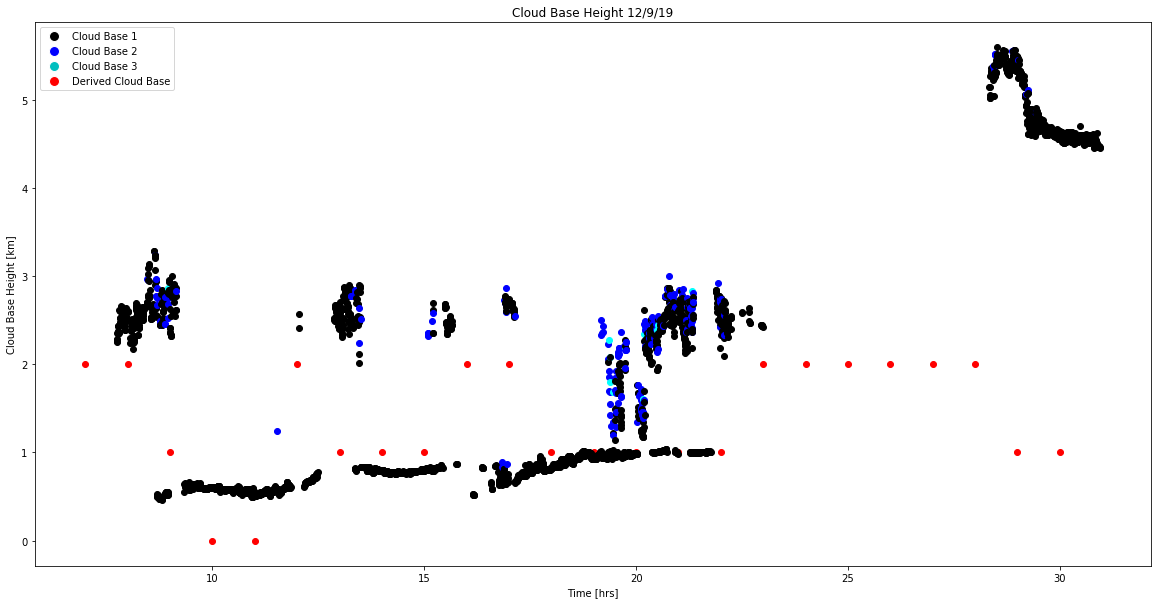

In [4]:
height_index = np.zeros(len(hourly_times))
for i in range(len(hourly_times)):
    #Find the derived cloud height be comparing the lapse rate temperature to the derived temperature at each time
    height_index[i] = np.argmin(abs(lapse_temp[i] - T_derived[hourly_index[i]]))

#Overplot the derived cloud base temperatures on the cloud height plot
plt.figure(figsize = [20, 10])
plt.scatter(hourly_times, height_index, color = 'red')
    
for i in range(len(cloud_base1)):
    
    if cloud_base1[i] != 0: 
        plt.plot(utc[i], cloud_base1[i], 'o', color = 'black')
        
    if cloud_base2[i] != 0:
        plt.plot(utc[i], cloud_base2[i], 'o', color= 'blue')
    
    if cloud_base3[i] != 0:
        plt.plot(utc[i], cloud_base3[i], 'o', color= 'cyan')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cloud Base 1', markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cloud Base 2', markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Cloud Base 3', markerfacecolor='c', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Derived Cloud Base', markerfacecolor='r', markersize=10)]

plt.legend(handles=legend_elements)

        
plt.xlabel('Time [hrs]')
plt.ylabel('Cloud Base Height [km]')
plt.title('Cloud Base Height 12/9/19')
plt.show()




#### Climatology: Everyday in the Year (2018)

There were 21 cloudy days in 2018.
There were 118 sunny days in 2018.


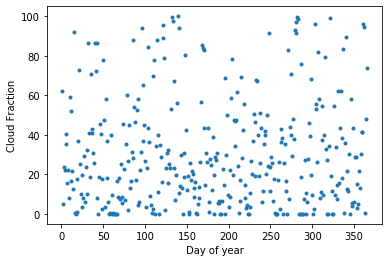

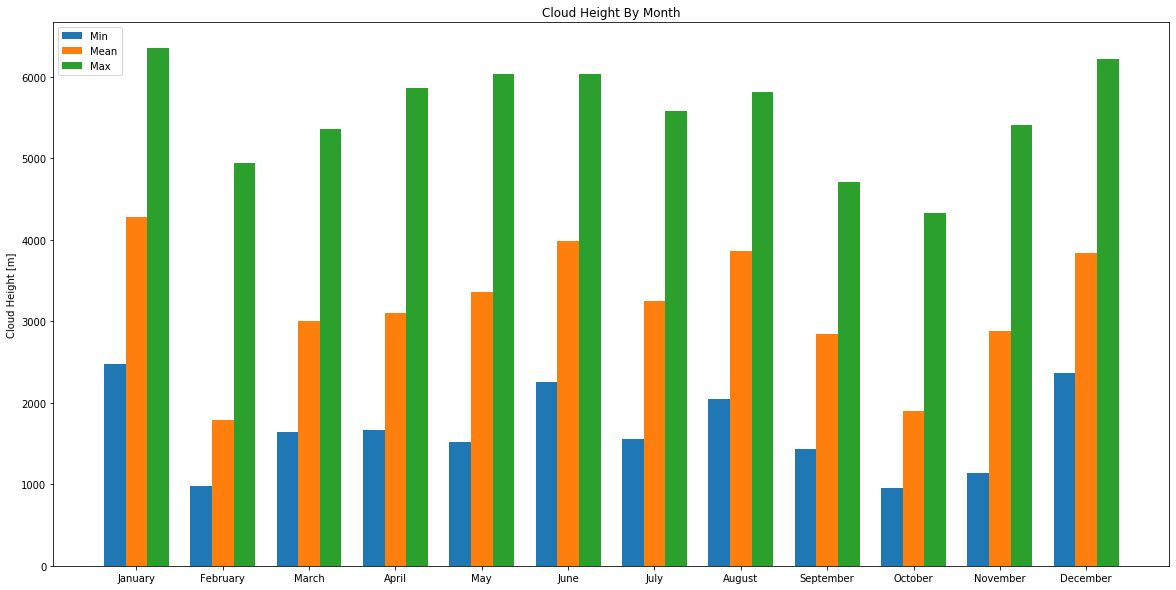

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import urllib
from matplotlib.lines import Line2D
import datetime
from matplotlib.pyplot import cm
import calendar
import h5py
import os.path
from sys import exit as ext


    
class cloud_height:
    
    def __init__(self, date, dataset,h5 = None):   
        if h5 is None: # If "h5" keyword was not set, then we actually need to read the file from the web, rather than restoring it from the hard drive
            url = 'https://skywatch.colorado.edu/data/'
            # get julian day (requested date)
            y0=int(date[0:4]); m0=int(date[5:7]); d0= int(date[8:10])       
            jul    = [] # initialize julian day
            loc    = [] # initialize local times
            dat1    = [] # cloud base 1 [m]
            dat2    = [] # cloud base 2 [m]
            dat3    = [] # cloud base 3 [m]
            #get url based on selected dataset and date
            url=url+dataset+date[2:]+'.dat'
            print('Reading: ',url)
            hh0=0.          # incremented by 24 each time we pass midnight
            loc0previous=0. # retains current time; if time switches back below that, will increment "hh0"
            jday = (datetime.datetime(y0,m0,d0)-datetime.datetime(y0,1,1)).total_seconds()/86400.0 + 1.0
            try:
                lines  = urllib.request.urlopen(url).readlines()
                for line in lines[5:]: # go through all lines, ignoring first three (header)
                    entries = line.decode("utf-8").split("\t")
                    columns = []       # will contain columns
                    for entry in entries:
                        if len(entry) > 1: columns.append(entry)
                 
                    hhmmX = columns[0] # assigns time, filling in leading '0'
                    hh    = float(hhmmX[0:2])
                    self.doy = jday
                    mm    = float(hhmmX[3:5])
                    ss    = float(hhmmX[6:8])
                    loc0  = hh+mm/60.+ss/3600.+hh0
                    if loc0<loc0previous:
                        hh0=hh0+24.
                        loc0=loc0+hh0
                    loc0previous=loc0
                    loc.append(loc0)
                    jul.append(jday+loc0/24.) 
                    dat1.append(float(columns[1]))
                    dat2.append(float(columns[2]))
                    dat3.append(float(columns[3]))
            except:
                print("website not found ",date)
                pass
            self.jul = np.array(jul)
            self.loc = np.array(loc)
            self.h1 = np.array(dat1)
            self.h2 = np.array(dat2)
            self.h3 = np.array(dat3)
            self.date = date
            self.doy  = int(jday)
            self.year = date[0:4]
        else:
           h5f = h5py.File(h5, "r")
           self.jul = h5f['jul'][...]
           self.loc = h5f['loc'][...]
           self.h1  = h5f['h1'][...]
           self.h2  = h5f['h2'][...]
           self.h3  = h5f['h3'][...]
           self.date= str(h5f['date'][...])
           self.doy = int(h5f['doy'][...])
           self.year= str(h5f['year'][...])
           try: # If statistics exist, restore them, if not set them to zero
               self.cf=float(h5f['cf'][...])
               self.min=float(h5f['min'][...])
               self.max=float(h5f['max'][...])
               self.mean=float(h5f['mean'][...])
           except:
               self.cf=0
               self.min=0
               self.max=0
               self.mean=0
           h5f.close()           

    def plot(self):
        plt.plot(self.loc,self.h1,'k.')
        plt.xlabel('Local Time [h]')
        plt.ylabel('Cloud Base Height [m]')
        plt.title(self.date+' Cloud Fraction '+str(round(self.cf,1))+'%')

        
    def stats(self): # of lowest cloud layer, calculate min, max, mean of day & cloud fraction
        tot=len(self.h1) # total number of data points
        flt=np.where(self.h1>0)
        cld=len(flt[0])  # number of cloudy data points
        if len(flt[0]>0):
            mn =np.min(self.h1[flt])
            mx =np.max(self.h1[flt])
            mm =np.mean(self.h1[flt])
            self.min=mn
            self.max=mx
            self.mean=mm
        
        if tot != 0:
            self.cf = float(cld)/float(tot)*100.

        else:
            self.cf = 0.
    
    
    def save(self):
        file = './'+self.year+'_'+str(int(self.doy)).zfill(3)+'.h5'
        print('Saving data to: '+file)
        h5 = h5py.File(file, "w")
        h5['jul'] = self.jul
        h5['loc'] = self.loc
        h5['h1']  = self.h1
        h5['h2']  = self.h2
        h5['h3']  = self.h3
        h5['date']= self.date
        h5['doy'] = self.doy
        h5['year']= self.year
        if hasattr(self,'mean'):
            h5['mean']= self.mean
            h5['min'] = self.min
            h5['max'] = self.max
            h5['cf']  = self.cf
        h5.close()
        
def jday2yyyymmdd(y,jd):
    month = 1
    while jd - calendar.monthrange(y,month)[1] > 0 and month <= 12:
        jd = jd - calendar.monthrange(y,month)[1]
        month = month + 1
    return(y,month,jd)


def monthly_stats(y, doy_list, mean_list, max_list, min_list):
    y,m,d = jday2yyyymmdd(y, doy_list[-1])
    month_list = np.linspace(1, m, m)
    day_in_year = 0
    mean_month = np.zeros(len(month_list))
    min_month = np.zeros(len(month_list))
    max_month = np.zeros(len(month_list))
    for i in month_list:
        
        days_in_month = calendar.monthrange(y,int(i))[1]
        mean_month[int(i-1)] = np.mean(mean_list[day_in_year:days_in_month + day_in_year])
        min_month[int(i-1)] = np.mean(min_list[day_in_year:days_in_month + day_in_year])
        max_month[int(i-1)] = np.mean(max_list[day_in_year:days_in_month + day_in_year]) 
        
        day_in_year += days_in_month


    return(month_list, mean_month, min_month, max_month)


if __name__ == '__main__':

    # Test one day
    if False:
        doy = 345
        y,m,d = jday2yyyymmdd(2019,doy)
        date  = str(y).zfill(2)+'_'+str(m).zfill(2)+'_'+str(d).zfill(2)    
        ch=cloud_height(date,'ceil_')
        ch.stats()   
        ch.plot()   

    # Read range of dates in a year, do some simple statistics, and write everything to individual h5 files for  a day
    if True:
        year  = 2018
        m0,d0 = 1,1    # start (m,d)
        m1,d1 = 12,31  # end (m,d)
        j0    = int((datetime.datetime(year,m0,d0)-datetime.datetime(year,1,1)).total_seconds()/86400.0 + 1.0)
        j1    = int((datetime.datetime(year,m1,d1)-datetime.datetime(year,1,1)).total_seconds()/86400.0 + 1.0)
        
        doy_list = []
        cf_list  = []
        mean_list  = []
        min_list  = []
        max_list  = []
        cloudy_days = 0
        sunny_days = 0
        for doy in range(j0,j1+1):
            doy_list.append(doy) # keep track of days
            y,m,d = jday2yyyymmdd(year,doy)
            date  = str(y).zfill(2)+'_'+str(m).zfill(2)+'_'+str(d).zfill(2)  
            # First, check if h5 file is already in existance for this date
            h5 = '../dat/'+str(year)+'_'+str(doy).zfill(3)+'.h5'
            if os.path.isfile(h5):
                #print('Open and read '+h5)
                ch = cloud_height(date,'ceil_h',h5=h5)
            else:
                ch=cloud_height(date,'ceil_')
                ch.stats()   
                ch.save()   
           # print('Cloud fraction that day:',round(ch.cf,2),'%')
            cf_list.append(ch.cf) # keep track of cloud fraction
            mean_list.append(ch.mean) # keep track of mean
            min_list.append(ch.min) # keep track of min
            max_list.append(ch.max) # keep track of max
            
            #How many days of sunshine? Threshold = 87.5%
            if ch.cf > 87.5:
                cloudy_days += 1
            if ch.cf < 12.5:
                sunny_days += 1
        
        print('There were %d cloudy days in %d.' %(cloudy_days,year))
        print('There were %d sunny days in %d.' %(sunny_days,year))
        
        mean_list = np.array(mean_list)
        min_list = np.array(min_list)
        max_list = np.array(max_list)
        plt.plot(doy_list,cf_list,'.')
        plt.xlabel('Day of year')
        plt.ylabel('Cloud Fraction')
        plt.show()
        
        month_list, mean_month, min_month, max_month = monthly_stats(year, doy_list, mean_list, max_list, min_list)
       
        
        labels = calendar.month_name[1:int(month_list[-1]) + 1]
        x = np.arange(len(labels))  # the label locations
        width = 0.25  # the width of the bars
    
        fig, ax = plt.subplots(figsize = [20, 10])
        rects1 = ax.bar(x - width, min_month, width, label='Min')
        rects2 = ax.bar(x, mean_month, width, label='Mean')
        rects3 = ax.bar(x + width, max_month, width, label='Max')
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Cloud Height [m]')
        ax.set_title('Cloud Height By Month')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        plt.show()
        

        

#### Climatology: One Month Every Year (January)

## Discussion

#### Programming Challenges

- The ceilometer dataset is very large and therefore it takes a very long time to read in just one day's worth of data. This causes extremely long runtimes when attempting to look at multiple years of data.

- Plotting all the backscatter data proved challenging due to the volume of data at hand.

- No units are given in the dataset for backscatter radiation, so this had to be left as an unknown.

- Assuming the dry adiabatic lapse rate is not very accurate in deriving cloud height. 

- Creating a 'climatology' using multiple year's worth of data takes about an hour to run. This is not ideal, especially if these visualizations will be hosted on a website.

- There was no elegant way to filter out 'zero' or nonexistant cloud heights from the data set, which either made presentation of the data difficult or required additional processing time.

#### Contributions

All data readers were taken from class but each reader was specialized to read the ceilometer and pyrgeometer data. All of the calculations for deriving cloud base temperature were our own contributions. The CLOUDS class was borrowed from another in class lab and tailored to our needs. 

#### Team Member Roles

- Matt: Code, report writing
- Lara: Code, report writing